http://imagesci.ece.cmu.edu/files/paper/2019/PhaseCam_ICCP19.pdf

#Imports

In [1]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
# import random
# import glob
# import os

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
# import torchsummary as summary
from torch.optim import lr_scheduler
from torch.autograd import Variable
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#DATA

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
ls

12octUnet_monocular_depth-Copy1.ipynb           UNetDepth2.pth
12octUnet_monocular_depth.ipynb                 UNetDepth3drop.pth
mikhil@10.107.2.120                             UNetDepth3.pth
mikhil@10.107.2.130                             UNetDepth.pth
nyu_depth_v2_labeled.mat.1                      Untitled.ipynb
torch-1.2.0+cpu-cp36-cp36m-win_amd64.whl        wget-log
torchvision-0.4.0+cpu-cp36-cp36m-win_amd64.whl


In [5]:
# from scipy.io import loadmat
import h5py

files = h5py.File('nyu_depth_v2_labeled.mat.1','r')

In [6]:
# plt.show()
# plt.imshow(files['depths'][1].transpose((1,0)))
print(files['images'][0].shape)
# print(files['images'][0].shape[0])
np.min(files['depths'][1])

(3, 640, 480)


1.1237347

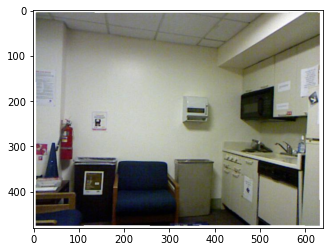

In [7]:
plt.imshow(files['images'][0].T)

#DATALOADER Class

In [7]:
class ImDataNYU(Dataset):
    def calculate_mean(self, images):
        mean_image = np.mean(images, axis=0)
        return mean_image

    def __init__(self, filename, Mode, rgb_transform = None, depth_transform = None):
        f = h5py.File(filename, 'r')
        images_data = f['images'][0:1449]
        depths_data = f['depths'][0:1449]

        if Mode == "training":
            self.images = images_data[0:1150]
            self.depths = depths_data[0:1150]
        elif Mode == "validation":
            self.images = images_data[1150:1350]
            self.depths = depths_data[1150:1350]

        elif Mode == "test":
            self.images = images_data[1350:]
            self.depths = depths_data[1350:]

        self.rgb_transform = rgb_transform
        self.depth_transform = depth_transform
        self.mean_image = self.calculate_mean(images_data[0:1449])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # image = (image - self.mean_image)/np.std(image)
        image = image.transpose((2, 1, 0)) #Verticslly jacked image
        #image = Image.fromarray(image)
        if self.rgb_transform:
            image = self.rgb_transform(image)

        depth = self.depths[idx]
        #depth = np.reshape(depth, (1, depth.shape[0], depth.shape[1]))
        depth = depth.transpose((1, 0)) #Verticslly jacked depth
        if self.depth_transform:
            depth = self.depth_transform(depth)
        #sample = {'image': image, 'depth': depth}
        return image,depth


#Augmengt the data 

In [8]:
#Original DATA
dataset_location='nyu_depth_v2_labeled.mat.1'
batch_size= 72
IMAGE_HEIGHT, IMAGE_WIDTH = 256 , 256
rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

og_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = rgb_transforms, depth_transform = depth_transforms)
# train_loader = torch.utils.data.DataLoader(og_data,batch_size = batch_size, shuffle = True)

In [9]:
#Vertical_Flip data

Vflip_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.RandomVerticalFlip(p=1.0),
                                         transforms.ToTensor()
                                         ])
Vflip_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.RandomVerticalFlip(p=1.0),
                                           transforms.ToTensor()
                                           ])

Vflip_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = Vflip_rgb_transforms, depth_transform = Vflip_depth_transforms)

In [10]:
#Horizontal_Flip data

gauss_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                         transforms.ToTensor()
                                         ])
g_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
#                                            transforms.RandomHorizontalFlip(p=1.0),
                                           transforms.ToTensor()
                                           ])

gauss_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = gauss_rgb_transforms, depth_transform = g_depth_transforms)

In [11]:
#rotn data
rot_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.RandomRotation(degrees=(45)),
                                         transforms.ToTensor()
                                         ])
rot_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.RandomRotation(degrees=(45)),
                                           transforms.ToTensor()
                                           ])

rot_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = rot_rgb_transforms, depth_transform = rot_depth_transforms)

#Data Loader

In [12]:
#CenterCrop(size=256)
crop_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.CenterCrop(size=256),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
crop_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.CenterCrop(size=256),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

crop_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = crop_rgb_transforms, depth_transform = crop_depth_transforms)

In [13]:
# RandomEqualize(p=0.5)
#CenterCrop(size=256)
eq_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.RandomEqualize(p=1.0),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
eq_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.CenterCrop(size=256),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

eq_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = crop_rgb_transforms, depth_transform = crop_depth_transforms)

In [14]:
#Total data
# total_data = torch.utils.data.ConcatDataset([og_data, rot_data ,gauss_data ])
total_data = torch.utils.data.ConcatDataset([og_data,rot_data,crop_data ,Vflip_data , gauss_data ]) #Vflip_data , Hflip_data
#total_data = torch.utils.data.ConcatDataset([og_data,Vflip_data])    #rot_data, ,Hflip_data
train_loader = torch.utils.data.DataLoader(total_data,batch_size = batch_size, shuffle = True)

In [15]:
#crop_data ,rcr_data #Validation set
validation_data = ImDataNYU( dataset_location,Mode='validation', rgb_transform = rgb_transforms, depth_transform = depth_transforms)
val_loader = torch.utils.data.DataLoader(validation_data,batch_size = batch_size, shuffle = False)

#model

In [16]:
class DoubleConv(nn.Module):
  def __init__(self,in_chan,out_chan):
    super(DoubleConv,self).__init__()
    self.conv  =  nn.Sequential(
        nn.Conv2d(in_chan,out_chan,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_chan),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_chan,out_chan,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_chan),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    x = self.conv(x)
    return x
    
class UNetDepth(nn.Module):
  def __init__(self,feature = 16*[32,64,128,256,512]):
    super(UNetDepth,self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.enc1 = DoubleConv(3,feature[0])
    self.enc2 = DoubleConv(feature[0],feature[1])
    self.enc3 = DoubleConv(feature[1],feature[2])
    self.enc4 = DoubleConv(feature[2],feature[3])
    self.enc5 = DoubleConv(feature[3],feature[4])
    self.upsample1 = nn.ConvTranspose2d(in_channels=feature[4],out_channels=feature[3],kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(in_channels=feature[3],out_channels=feature[2],kernel_size=2,stride=2)
    self.upsample3 = nn.ConvTranspose2d(in_channels=feature[2],out_channels=feature[1],kernel_size=2,stride=2)
    self.upsample4 = nn.ConvTranspose2d(in_channels=feature[1],out_channels=feature[0],kernel_size=2,stride=2)
    self.dec1 = DoubleConv(feature[4],feature[3])
    self.dec2 = DoubleConv(feature[3],feature[2])
    self.dec3 = DoubleConv(feature[2],feature[1])
    self.dec4 = DoubleConv(feature[1],feature[0])
    self.out  = nn.Conv2d(feature[0],1,kernel_size=1)
    self.drop = nn.Dropout2d(p=0.2)

  def forward(self,x):
    #encoder
                          #inchannel 3 in_image = 256 256
    x1  = self.enc1(x)    #inchannel=3 outchannel=32
    x1  = self.drop(x1)
    x2  = self.pool(x1)   # 32 128 128
    x2  = self.drop(x2)   ##########$################
    x3  = self.enc2(x2)   # inchannel=32 outchannel=64
    x4  = self.pool(x3)   # 64 64 64 
    x4  = self.drop(x4)   #######################
    x5  = self.enc3(x4)   # inchannel=64 outchannel=128
    x6  = self.pool(x5)   #128 32 32
    x7  = self.enc4(x6)   #inchannel=128 outchannel=256
    x8  = self.pool(x7)   #256 16 16
    x9  = self.enc5(x8)   #inchannel=256 outchannel=512
    #print("x9",x9.shape)
    #decoder
    x10 = torch.cat([self.upsample1(x9),x7],dim=1)
    #print("x10", x10.shape)
    x11 = self.dec1(x10)
    #print("x11", x11.shape)
    x12 = torch.cat([self.upsample2(x11),x5],dim=1)
    #print("x12", x12.shape)
    x13 = self.dec2(x12)
    x13 = self.drop(x13)  ###############
    #print("x13", x13.shape)
    x14 = torch.cat([self.upsample3(x13),x3],dim=1)
    x15 = self.dec3(x14)
    #print("x15", x15.shape)
    x16 = torch.cat([self.upsample4(x15),x1],dim=1)
#     x16 = self.drop(x16)   ################
    x17 = self.dec4(x16)
    #print("x17", x17.shape)
    out = self.out(x17)
    #print("out", out.shape)
    return F.relu(out)

net = UNetDepth().to(device)
model = torch.nn.DataParallel(net, device_ids=[0, 1, 2, 3])

In [17]:
# from torchsummary import summary
# summary(model,(3,256,256))

#training

In [18]:
# def ScaleInvariantLoss(output, depth):
#     # di = output - target
#     output = torch.log(output+1)
#     target = torch.log(depth+1)
#     di = torch.abs(depth - output)
#     n = (IMAGE_HEIGHT*IMAGE_WIDTH)
#     di2 = torch.pow(di, 2)
#     fisrt_term = torch.sum(di2)/n
#     second_term = torch.pow(torch.sum(di), 2)/ (n**2)
#     loss = fisrt_term - second_term
#     return loss.mean()

def gradLoss(output, depth):
    # di = grad(output - target)
    di = torch.gradient(output-depth)
    n = IMAGE_HEIGHT*IMAGE_WIDTH
    fisrt_term = torch.sum(di[1])/np.sqrt(n)
    second_term = torch.sum(di[2])/ np.sqrt(n)
    loss = torch.abs(fisrt_term) + torch.abs(second_term)
    return loss

#loss_f = nn.MSELoss()

In [19]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
#Parameters
epochs=20
LEARNING_RATE = 1e-3 #1e-3
MOMENTUM  = 1e-4
WEIGHT_DECAY =1e-4 #1e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM ,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

loss_f = nn.MSELoss()
training_loss=[]
validation_loss=[]
for epoch in range(epochs):
  loop = tqdm(enumerate(train_loader), total = len(train_loader),desc = f'Epoch [{epoch+1}/{epochs}]')
  running_loss=0
  for batch_idx, (image,depth) in loop:
    image=image.to(device)
    depth=depth.to(device)
    optimizer.zero_grad()
    output= model(image)
    loss = torch.sqrt(loss_f(output,depth))  #+ (gradLoss(output,depth))
    loss.backward()
    optimizer.step()
    running_loss+=loss
  running_loss/=(len(train_loader))
  training_loss.append(running_loss)
  print (f'Epoch [{epoch+1}/{epochs}], TrainLoss: {running_loss:.4f}',end='')

  with torch.no_grad():
    running_val_loss=0
    for val_image,val_depth in val_loader:
      val_image=val_image.to(device)
      val_depth=val_depth.to(device)
      val_out = model(val_image)
      val_loss =  torch.sqrt(loss_f(val_depth,val_out))  #+ (gradLoss(output,depth))
      running_val_loss +=val_loss
    running_val_loss/=(len(val_loader))
    validation_loss.append(running_val_loss)
    print(f'\tValLoss_: {running_val_loss: .4f}')
PATH = './UNetDepth3drop.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/20]: 100%|█████████████████████████████| 80/80 [01:03<00:00,  1.26it/s]


Epoch [1/20], TrainLoss: 2.4096	ValLoss_:  2.4001


Epoch [2/20]: 100%|█████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [2/20], TrainLoss: 1.8897	ValLoss_:  1.8819


Epoch [3/20]: 100%|█████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]


Epoch [3/20], TrainLoss: 1.5501	ValLoss_:  1.5850


Epoch [4/20]: 100%|█████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [4/20], TrainLoss: 1.3822	ValLoss_:  1.4845


Epoch [5/20]: 100%|█████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]


Epoch [5/20], TrainLoss: 1.3078	ValLoss_:  1.3815


Epoch [6/20]: 100%|█████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [6/20], TrainLoss: 1.2819	ValLoss_:  1.3874


Epoch [7/20]: 100%|█████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]


Epoch [7/20], TrainLoss: 1.2767	ValLoss_:  1.3854


Epoch [8/20]: 100%|█████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [8/20], TrainLoss: 1.2633	ValLoss_:  1.3470


Epoch [9/20]: 100%|█████████████████████████████| 80/80 [00:58<00:00,  1.37it/s]


Epoch [9/20], TrainLoss: 1.2547	ValLoss_:  1.3525


Epoch [10/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [10/20], TrainLoss: 1.2426	ValLoss_:  1.3806


Epoch [11/20]: 100%|████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [11/20], TrainLoss: 1.2408	ValLoss_:  1.3319


Epoch [12/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [12/20], TrainLoss: 1.2340	ValLoss_:  1.3886


Epoch [13/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]


Epoch [13/20], TrainLoss: 1.2290	ValLoss_:  1.3708


Epoch [14/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]


Epoch [14/20], TrainLoss: 1.2200	ValLoss_:  1.3304


Epoch [15/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]


Epoch [15/20], TrainLoss: 1.2162	ValLoss_:  1.3347


Epoch [16/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [16/20], TrainLoss: 1.2057	ValLoss_:  1.3686


Epoch [17/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.39it/s]


Epoch [17/20], TrainLoss: 1.1973	ValLoss_:  1.3280


Epoch [18/20]: 100%|████████████████████████████| 80/80 [00:58<00:00,  1.38it/s]


Epoch [18/20], TrainLoss: 1.1913	ValLoss_:  1.3150


Epoch [19/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [19/20], TrainLoss: 1.1884	ValLoss_:  1.3244


Epoch [20/20]: 100%|████████████████████████████| 80/80 [00:57<00:00,  1.38it/s]


Epoch [20/20], TrainLoss: 1.1748	ValLoss_:  1.3254


In [21]:
# a= np.arange(epochs+1)
# plt.plot(a,training_loss)
# plt.plot(a,validation_loss)

In [5]:
PATH = './UNetDepth3drop.pth'
ff = UNetDepth().to(device)
check = torch.nn.DataParallel(ff, device_ids=[0, 1, 2, 3])
check.load_state_dict(torch.load(PATH))

NameError: name 'UNetDepth' is not defined

torch.Size([3, 256, 256])


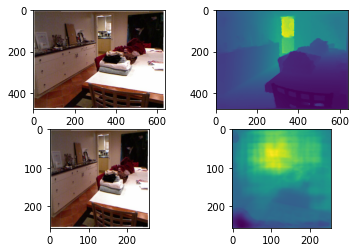

In [31]:
f, axarr = plt.subplots(2,2)
image_test =  files['images'][1440]
depth_test =  files['depths'][1440]
axarr[0,0].imshow(image_test.T)
axarr[0,1].imshow(depth_test.T)
# img=rgb_transforms(image_test.T)
img=rgb_transforms(image_test.T)
# dep=depth_transforms(Image.fromarray(np.uint8(depth_test.T)))
dep=depth_transforms(depth_test.T)
print(img.shape)
img2=img.view(1, 3, IMAGE_HEIGHT,IMAGE_WIDTH)
test_out = check(img2.to(device))
axarr[1,1].imshow(test_out[0][0].detach().cpu().numpy(), interpolation="bilinear")
axarr[1,0].imshow(img.permute(1,2,0))

In [32]:
# p = rcr_depth_transforms(files['depths'][1420].T)
# plt.imshow(np.transpose(p[0].detach().cpu().numpy(), (0,1)), interpolation="bilinear")

In [33]:
l = torch.sqrt(loss_f(dep.to(device),test_out))
l

tensor(1.0204, device='cuda:0', grad_fn=<SqrtBackward>)

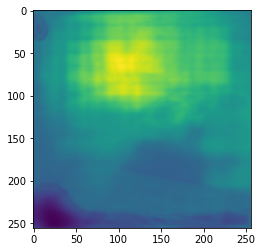

In [34]:
plt.imshow(test_out[0][0].detach().cpu().numpy(), interpolation="bilinear")

In [27]:
# a = np.log(test_out[0][0].detach().cpu().numpy()+1e-3)
# plt.imshow(a)

In [28]:
# class FineNetwork(nn.Module):
#     def __init__(self,init=True):
#         super(FineNetwork,self).__init__()
#         self.conv1 = nn.Conv2d(3, 63, kernel_size = 9, padding = 'same')
#         self.pool = nn.MaxPool2d(2)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size = 5, padding = 'same')
#         self.conv3 = nn.Conv2d(64, 1, kernel_size = 5, padding = 'same')
        
#     def forward(self,x,y):
#         x = F.relu(self.conv1(x))
#         x = torch.cat((x,y),1)
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         return x
    
        

In [29]:
# f1 = FineNetwork().to(device)
# fine = torch.nn.DataParallel(f1, device_ids=[0, 1, 2, 3])

In [30]:
# #Parameters
# epochs=10
# LEARNING_RATE = 1e-3 #1e-3
# MOMENTUM  = 1e-4
# WEIGHT_DECAY =1e-4 #1e-4
# # optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM ,weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

# loss_f = nn.MSELoss()
# training_loss=[]
# validation_loss=[]
# for epoch in range(epochs):
#   loop = tqdm(enumerate(train_loader), total = len(train_loader),desc = f'Epoch [{epoch+1}/{epochs}]')
#   running_loss=0
#   for batch_idx, (image,depth) in loop:
#     image=image.to(device)
#     depth=depth.to(device)
#     optimizer.zero_grad()
#     output= fine(image , check(image))
#     loss = torch.sqrt(loss_f(output,depth))  #+ (gradLoss(output,depth))
#     loss.backward()
#     optimizer.step()
#     running_loss+=loss
#   running_loss/=(len(train_loader))
#   training_loss.append(running_loss)
#   print (f'Epoch [{epoch+1}/{epochs}], TrainLoss: {running_loss:.4f}',end='')

#   with torch.no_grad():
#     running_val_loss=0
#     for val_image,val_depth in val_loader:
#       val_image=val_image.to(device)
#       val_depth=val_depth.to(device)
#       val_out = fine(val_image , check(val_image))
#       val_loss =  torch.sqrt(loss_f(val_depth,val_out))  #+ (gradLoss(output,depth))
#       running_val_loss +=val_loss
#     running_val_loss/=(len(val_loader))
#     validation_loss.append(running_val_loss)
#     print(f'\tValLoss_: {running_val_loss: .4f}')
# PATH = './fine.pth'
# torch.save(fine.state_dict(), PATH)